# Importing Libraries 

In [76]:
import nibabel as nib
import numpy as np
from scipy import ndimage
import tensorflow as tf
import os
import zipfile
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Conv2D,Flatten,Dense,PReLU,BatchNormalization,GlobalAveragePooling2D,GlobalAvgPool2D,InputLayer,MaxPooling2D,Dropout
from sklearn.model_selection import train_test_split
import random
from PIL import Image



# Data Processing 

In [77]:
def read_nifti_file(filepath):
    """Read and load volume"""

    # Define orientations
    ornt = np.array([[0,-1],
                [1, 1],
                [2, 1]])
    ornt2 = np.array([[2,-1],
                [1, -1],
                [0, -1]])
    ornt3 = np.array([[1,1],
                [0, 1],
                [2, 1]])

    # Read file
    scan = nib.load(filepath)
    
    # Check the mask volume and re-orient it
    if "Hippocampal" in filepath or "hippocampal" in filepath:
      #  print("Hippocampal")
        scan = scan.as_reoriented(ornt)
        

    # Check the whole-brain volume and re-orient it
    elif "N3" in filepath:
       # print("N3")
        scan = scan.as_reoriented(ornt2)
        
    if 'Whole_Brain'in filepath or "whole_Brain" in filepath:
       # print("Whole")
        scan = scan.as_reoriented(ornt2)
         
        
   # print(nib.aff2axcodes(scan.affine))
    # Get raw data
    scan = scan.get_fdata()

    return scan

In [78]:
def normalize(volume):
    max = np.amax(volume)
    min = np.amin(volume)
    return ((volume - min)/(max-min))

In [79]:
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)

    # Normalize
    normalized_volume = normalize(volume)

    return normalized_volume

In [80]:
def get_hippocampus_paths(rootdir):
    """Return the paths of the directory"""
    filenames=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if (("Hippocampal" in file) or ("hippocampal" in file)) and ("S38957" not in file) and ("S45892" not in file) and ("S15332" not in file) and ("S15857" not in file):
                filenames.append(os.path.join(subdir, file))
    return filenames

def get_processed_data_paths(rootdir):
    """Return the paths of the directory"""
    filenames=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if ("N3" in file) and ("S38957" not in file) and ("S45892" not in file) and ("S15332" not in file) and ("S15857" not in file):
                filenames.append(os.path.join(subdir, file))
    return filenames

def get_whole_brain_paths(rootdir):
    """Return the paths of the directory"""
    filenames=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if "Whole_Brain" in file:
                filenames.append(os.path.join(subdir, file))
    return filenames

In [81]:
def get_mask_slices_in_whole_brain(mask_scans,mask_scan,processed_data_scans, processed_data_scan, whole_brain_scans, whole_brain_scan):

    """Return each slice with its label"""
    
    labeled_slices=[]
    image_size=256

    for i in range(len(processed_data_scans)):
        #processed_data_scan = processed_data_scans[i]
        #processed_data_scan = np.asarray( processed_data_scans[i] * whole_brain_scans[i])
        processed_data_scan = np.asarray( processed_data_scans[i] )
        print((processed_data_scan.shape[2]))
        for z in range((processed_data_scan.shape[2])):
            # image = cv2.resize( processed_data_scan[:,:,j], (image_size, image_size),interpolation = cv2.INTER_AREA)
            labeled_slices.append(processed_data_scan[:,:,z])
    return labeled_slices  

In [82]:

#cropping

def cropping(img):
    xs,ys=np.where(img!=0)
    if len(xs)==0 or len(ys)==0:
        return img
    result = img[min(xs):max(xs)+1, min(ys):max(ys)+1]
    return result

In [ ]:
AD_Mask_paths = get_hippocampus_paths("/kaggle/input/adni-2d/Dataset-1/AD")
AD_paths = get_processed_data_paths("/kaggle/input/adni-2d/Dataset-1/AD")
AD_Whole_Brain_paths = get_whole_brain_paths("/kaggle/input/adni-2d/Dataset-1/AD")

print("AD: " + str(len(AD_paths)))
print("AD Mask Count: " + str(len(AD_Mask_paths)))
print("AD Whole Brain Count: " + str(len(AD_Whole_Brain_paths)))

x_train_AD=AD_paths[320:]
x_train_AD_Mask=AD_Mask_paths[320:]
x_train_AD_Whole_Brain=AD_Whole_Brain_paths[320:]
print("AD: " + str(len(x_train_AD)))
print("AD Mask Count: " + str(len(x_train_AD_Mask)))
print("AD Whole Brain Count: " + str(len(x_train_AD_Whole_Brain)))
AD_paths=[]
AD_Mask_paths=[]
AD_Whole_Brain_paths=[]
AD_scans = np.array([process_scan(path) for path in x_train_AD])
AD_Mask_scans = np.array([process_scan(path) for path in x_train_AD_Mask])
AD_Whole_Brain_scans = np.array([process_scan(path) for path in x_train_AD_Whole_Brain])

x_train_AD = []
x_train_AD_Mask = []
#x_train_AD_Whole_Brain = []
AD_slices= get_mask_slices_in_whole_brain(AD_Mask_scans,'AD_Mask_Scan',AD_scans,'AD_Scan',AD_Whole_Brain_scans, 'AD_Whole_Brain_scan' )
#AD_slices= get_mask_slices_in_whole_brain(AD_Mask_scans,'AD_Mask_Scan',AD_scans,'AD_Scan')
AD_slices = np.array(AD_slices)
AD_scans = []
AD_Mask_scans = []

# print(AD_slices[0].shape)
for i in range(len(AD_slices)):
    
    im=np.asarray(AD_slices[i])
    im=cropping(im)
    im=np.abs(((im-im.min())/(im.max()-im.min()))*255)
    img = Image.fromarray(im)
    
    img=img.convert("L")
    i = i 
    img.save("/kaggle/working/image" +str(i)+".png" )



 

AD: 339
AD Mask Count: 339
AD Whole Brain Count: 339
AD: 19
AD Mask Count: 19
AD Whole Brain Count: 19


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/co

192
240
192
256
256
256
192
256
256
256
256
256
256
256
192
192
256
256
256


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [70]:
MCI_Mask_paths = get_hippocampus_paths("/kaggle/input/adni-2d/Dataset-1/MCI")
MCI_paths = get_processed_data_paths("/kaggle/input/adni-2d/Dataset-1/MCI")
MCI_Whole_Brain_paths = get_whole_brain_paths("/kaggle/input/adni-2d/Dataset-1/MCI")

print("MCI: " + str(len(MCI_paths)))
print("MCI Mask Count: " + str(len(MCI_Mask_paths)))
print("MCI Whole Brain Count: " + str(len(MCI_Whole_Brain_paths)))
x_train_MCI = MCI_paths[750:]
x_train_MCI_Mask = MCI_Mask_paths[750:]
x_train_MCI_Whole_Brain = MCI_Whole_Brain_paths[750:]
print("MCI: " + str(len(x_train_MCI)))
print("MCI Mask Count: " + str(len(x_train_MCI_Mask)))
print("MCI Whole Brain Count: " + str(len(x_train_MCI_Whole_Brain)))


MCI_paths=[]
MCI_Mask_paths=[]
MCI_Whole_Brain_paths=[]

MCI_scans = np.array([process_scan(path) for path in x_train_MCI])
MCI_Mask_scans = np.array([process_scan(path) for path in x_train_MCI_Mask])
MCI_Whole_Brain_scans = np.array([process_scan(path) for path in x_train_MCI_Whole_Brain])

x_train_MCI = []
x_train_MCI_Mask = []
x_train_MCI_Whole_Brain = []
MCI_slices= get_mask_slices_in_whole_brain(MCI_Mask_scans,'MCI_Mask_Scan',MCI_scans,'MCI_Scan', MCI_Whole_Brain_scans, 'MCI_Whole_Brain_scan')
#MCI_slices= get_mask_slices_in_whole_brain([0,1,0],MCI_Mask_scans,'MCI_Mask_Scan',MCI_scans,'MCI_Scan')
MCI_scans = []
MCI_Mask_scans = []
MCI_Whole_Brain_scans = []

MCI_slices = np.array(MCI_slices)


print(MCI_slices[0].shape)
for i in range(len(MCI_slices)):

    im=np.asarray(MCI_slices[i])
    im=cropping(im)
    im=np.abs(((im-im.min())/(im.max()-im.min()))*255)
    img = Image.fromarray(im)   
    img=img.convert("L")
    i = i + 15398
    img.save("/kaggle/working/Processed_MCI_F/image" +str(i)+".png" )


MCI: 805

MCI Mask Count: 805

MCI Whole Brain Count: 805

MCI: 55

MCI Mask Count: 55

MCI Whole Brain Count: 55


C:\Users\nohae\AppData\Local\Temp\ipykernel_17728\1232889772.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

  MCI_scans = np.array([process_scan(path) for path in x_train_MCI])

C:\Users\nohae\AppData\Local\Temp\ipykernel_17728\1232889772.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

  MCI_Mask_scans = np.array([process_scan(path) for path in x_train_MCI_Mask])

C:\Users\nohae\AppData\Local\Temp\ipykernel_17728\1232889772.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

(256, 256)


In [74]:
CN_Mask_paths = get_hippocampus_paths("/kaggle/input/adni-2d/Dataset-1/CN")
CN_paths = get_processed_data_paths("/kaggle/input/adni-2d/Dataset-1/CN")
CN_Whole_Brain_paths = get_whole_brain_paths("/kaggle/input/adni-2d/Dataset-1/CN")

print("CN: " + str(len(CN_paths)))
print("CN Mask Count: " + str(len(CN_Mask_paths)))
print("CN Whole Brain Count: " + str(len(CN_Whole_Brain_paths)))

x_train_CN=CN_paths[360:]
x_train_CN_Mask=CN_Mask_paths[360:]
x_train_CN_Whole_Brain = CN_Whole_Brain_paths[360:]
print("CN: " + str(len(x_train_CN)))
print("CN Mask Count: " + str(len(x_train_CN_Mask)))
print("CN Whole Brain Count: " + str(len(x_train_CN_Whole_Brain)))


CN_paths=[]
CN_Mask_paths=[]
CN_Whole_Brain_paths=[]
CN_scans = np.array([process_scan(path) for path in x_train_CN])
CN_Mask_scans = np.array([process_scan(path) for path in x_train_CN_Mask])
CN_Whole_Brain_scans = np.array([process_scan(path) for path in x_train_CN_Whole_Brain])

x_train_CN = []
x_train_CN_Mask = []
x_train_CN_Whole_Brain = []
CN_slices= get_mask_slices_in_whole_brain(CN_Mask_scans,'CN_Mask_Scan',CN_scans,'CN_Scan', CN_Whole_Brain_scans, 'CN_Whole_Brain_scan')
#CN_slices= get_mask_slices_in_whole_brain([0,0,1],CN_Mask_scans,'CN_Mask_Scan',CN_scans,'CN_Scan')
CN_scans = []
CN_Mask_scans = []
CN_Whole_Brain_scans = []

CN_slices = np.array(CN_slices)


print(CN_slices[0].shape)
for i in range(len(CN_slices)):

    im=np.asarray(CN_slices[i])
    im=cropping(im)
    im=np.abs(((im-im.min())/(im.max()-im.min()))*255)
    img = Image.fromarray(im)   
    img=img.convert("L")
    i = i + 7723
    img.save("/kaggle/working/Processed_CN_F/image" +str(i)+".png" )

CN: 450

CN Mask Count: 450

CN Whole Brain Count: 450

CN: 90

CN Mask Count: 90

CN Whole Brain Count: 90


C:\Users\nohae\AppData\Local\Temp\ipykernel_17728\692224978.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

  CN_scans = np.array([process_scan(path) for path in x_train_CN])

C:\Users\nohae\AppData\Local\Temp\ipykernel_17728\692224978.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

  CN_Mask_scans = np.array([process_scan(path) for path in x_train_CN_Mask])

C:\Users\nohae\AppData\Local\Temp\ipykernel_17728\692224978.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuple

(256, 256)


In [12]:
# Concatenate and shuffle the slices 

data=np.concatenate((CN_slices,MCI_slices,AD_slices),axis=0)
CN_slices = []
MCI_slices = []
AD_slices = []
random.shuffle(data)

# Split the data to feature and label
img_data = []
img_labels = []
for features, label in data:
    img_data.append(features)
    img_labels.append(label)
print(len(img_labels))


5025


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


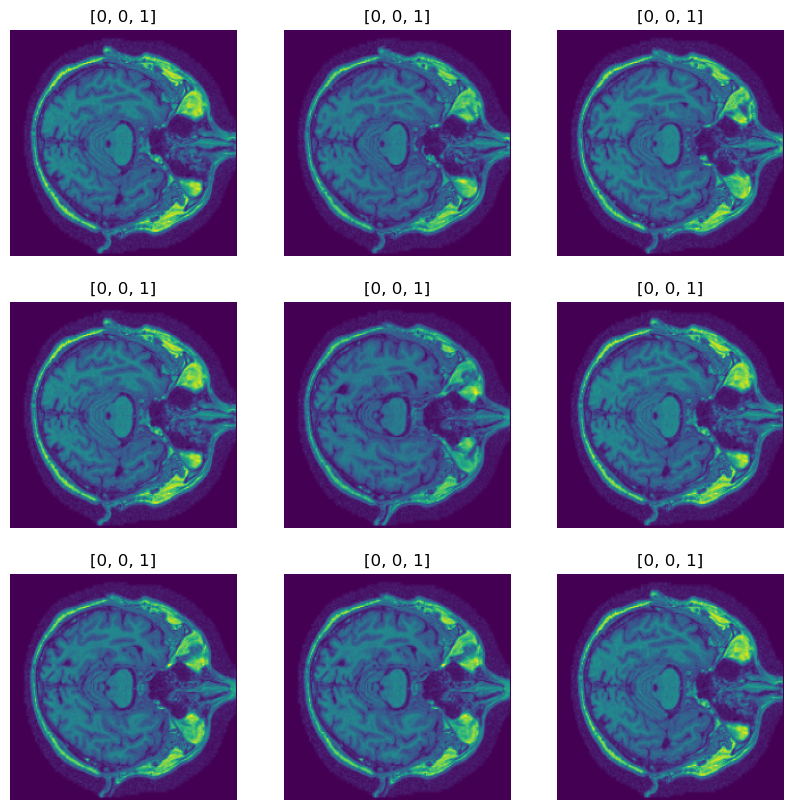

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img_data[i])
  plt.title(img_labels[i])
  plt.axis("off")

In [14]:
def train_preprocessing(image, label):
    """Process training data by rotating and adding a channel."""
    image = tf.expand_dims(image, axis=2)
    return image, label


def validation_preprocessing(image, label):
    """Process validation data by only adding a channel."""
    image = tf.expand_dims(image, axis=2)
    return image, label

In [15]:
full_dataset = tf.data.Dataset.from_tensor_slices((img_data, img_labels))
train_size = int(0.8*len(img_labels))
val_size = int(0.2 *len(img_labels))
test_size = int(0 *len(img_labels))

full_dataset = full_dataset.shuffle(len(img_labels))
train_loader = full_dataset.take(train_size)
# test_loader = full_dataset.skip(train_size)
validation_loader = full_dataset.skip(train_size).take(val_size)
# test_loader = test_loader.take(test_size)





batch_size = 20
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(5500)
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(2000)
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)    
)
 

In [16]:
for images,labels in train_loader.take(1):
    numpy_image = images.numpy()
    print(numpy_image.shape)

(200, 200)


In [17]:
def get_model():
    """Build a 2D convolutional neural network model."""

    model=Sequential([
        InputLayer([200,200,1]),
    Conv2D(filters=16,kernel_size=3, activation="relu", padding= "same"
         ),
   BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(filters=32,kernel_size=3, activation="relu",padding= "same"
            ),
           BatchNormalization(),
   MaxPooling2D(2),
     Conv2D(filters=64,kernel_size=3, activation="relu",padding= "same"
            ),
           BatchNormalization(),
    MaxPooling2D(2),
     Dropout(0.5),
    Flatten(),
     Dropout(0.5),
    Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(3, activation="softmax"),

    ])
    return model


# Build model.
model = get_model()
model.build()
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 200, 200, 16)      160       

                                                                 

 batch_normalization (BatchN  (None, 200, 200, 16)     64        

 ormalization)                                                   

                                                                 

 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         

 )                                                               

                                                                 

 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      

                                                                 

 batch_normalization_1 (Batc  (None, 100, 100, 32)     128       

 hNormalization)                                                 

                                        

In [18]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc"),tf.keras.metrics.AUC(name='auc')],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=20,restore_best_weights=True)

# Train the model, doing validation at the end of each epoch
epochs = 100
# Fit the model.
with tf.device('/GPU'):
    model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_cb, early_stopping_cb],
    )   


Epoch 1/100


2023-02-26 20:08:31.512652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 - 19s - loss: 1.1765 - acc: 0.7383 - auc: 0.8734 - val_loss: 2.4944 - val_acc: 0.7353 - val_auc: 0.8046 - 19s/epoch - 95ms/step

Epoch 2/100

201/201 - 5s - loss: 0.3799 - acc: 0.8694 - auc: 0.9637 - val_loss: 0.9443 - val_acc: 0.7254 - val_auc: 0.8617 - 5s/epoch - 26ms/step

Epoch 3/100

201/201 - 5s - loss: 0.2283 - acc: 0.9229 - auc: 0.9846 - val_loss: 0.3314 - val_acc: 0.8816 - val_auc: 0.9692 - 5s/epoch - 26ms/step

Epoch 4/100

201/201 - 5s - loss: 0.1765 - acc: 0.9425 - auc: 0.9897 - val_loss: 0.0754 - val_acc: 0.9711 - val_auc: 0.9987 - 5s/epoch - 24ms/step

Epoch 5/100

201/201 - 5s - loss: 0.1259 - acc: 0.9550 - auc: 0.9946 - val_loss: 0.0458 - val_acc: 0.9861 - val_auc: 0.9989 - 5s/epoch - 24ms/step

Epoch 6/100

201/201 - 5s - loss: 0.0989 - acc: 0.9659 - auc: 0.9966 - val_loss: 0.0415 - val_acc: 0.9871 - val_auc: 0.9996 - 5s/epoch - 24ms/step

Epoch 7/100

201/201 - 5s - loss: 0.0873 - acc: 0.9724 - auc: 0.9968 - val_loss: 0.0326 - val_acc: 0.9881 - val_auc: 0.9997

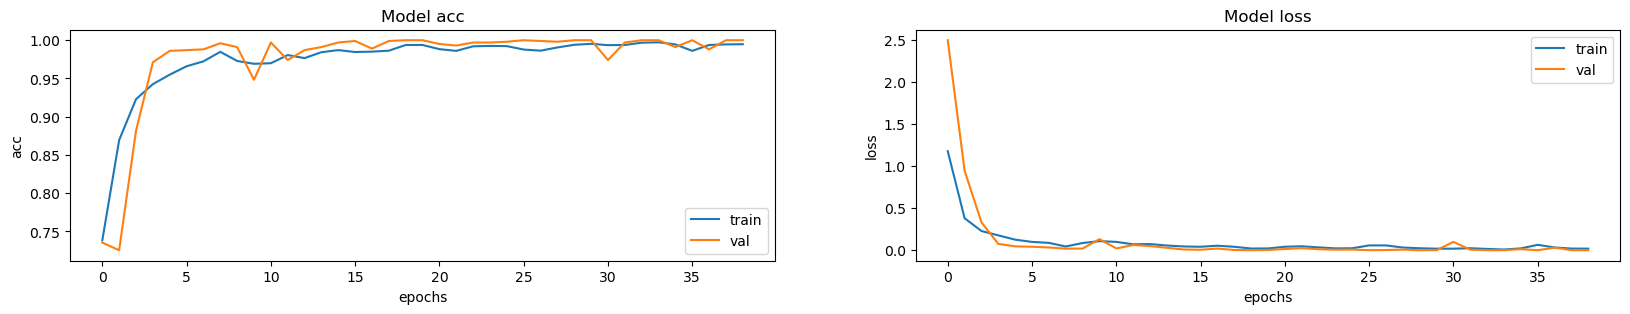

In [19]:

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [20]:
full_dataset = []
train_loader = []
validation_loader = []
img_data = []
img_labels = []

# Testing Model

In [21]:
# Read the scans.
AD_Mask_paths = get_hippocampus_paths("/kaggle/input/adni-2d/Dataset-1/AD")
AD_paths = get_processed_data_paths("/kaggle/input/adni-2d/Dataset-1/AD")
#AD_Whole_Brain_paths = get_whole_brain_paths("/kaggle/input/adni-2d/Dataset-1/AD")
print("AD: " + str(len(AD_paths)))
print("AD Mask Count: " + str(len(AD_Mask_paths)))
#print("AD Whole Brain Count: " + str(len(AD_Whole_Brain_paths)))

x_test_AD=AD_paths[100:115]
x_test_AD_Mask=AD_Mask_paths[100:115]
#x_test_AD_Whole_Brain=AD_Whole_Brain_paths[100:115]
AD_paths=[]
AD_Mask_paths=[]
#AD_Whole_Brain_paths=[]
print("AD: " + str(len(x_test_AD)))
print("AD Mask Count: " + str(len(x_test_AD_Mask)))
#print("AD Whole Brain Count: " + str(len(x_test_AD_Whole_Brain)))

AD_scans = np.array([process_scan(path) for path in x_test_AD])
AD_Mask_scans = np.array([process_scan(path) for path in x_test_AD_Mask])
#AD_Whole_Brain_scans = np.array([process_scan(path) for path in x_test_AD_Whole_Brain])

x_test_AD = []
x_test_AD_Mask = []
#x_test_AD_Whole_Brain = []
#AD_test_slices=get_mask_slices_in_whole_brain([1,0,0],AD_Mask_scans,'AD_Mask_Scan',AD_scans,'AD_Scan',AD_Whole_Brain_scans, 'AD_Whole_Brain_scan' )
AD_test_slices=get_mask_slices_in_whole_brain([1,0,0],AD_Mask_scans,'AD_Mask_Scan',AD_scans,'AD_Scan')
AD_scans = []
AD_Mask_scans = []
#AD_Whole_Brain_scans = []


AD: 339

AD Mask Count: 339

AD: 15

AD Mask Count: 15


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [22]:
CN_Mask_paths = get_hippocampus_paths("/kaggle/input/adni-2d/Dataset-1/CN")
CN_paths =  get_processed_data_paths("/kaggle/input/adni-2d/Dataset-1/CN")
#CN_Whole_Brain_paths = get_whole_brain_paths("/kaggle/input/adni-2d/Dataset-1/CN")

print("CN: " + str(len(CN_paths)))
print("CN Mask Count: " + str(len(CN_Mask_paths)))
#print("CN Whole Brain Count: " + str(len(CN_Whole_Brain_paths)))

x_test_CN=CN_paths[100:115]
x_test_CN_Mask=CN_Mask_paths[100:115]
#x_test_CN_Whole_Brain=CN_Whole_Brain_paths[100:115]
CN_paths=[]
CN_Mask_paths=[]
#CN_Whole_Brain_paths=[]
CN_scans = np.array([process_scan(path) for path in x_test_CN])
CN_Mask_scans = np.array([process_scan(path) for path in x_test_CN_Mask])
#CN_Whole_Brain_scans = np.array([process_scan(path) for path in x_test_CN_Whole_Brain])

x_test_CN = []
x_test_CN_Mask = []
#x_test_CN_Whole_Brain = []
#CN_test_slices= get_mask_slices_in_whole_brain([0,0,1],CN_Mask_scans,'CN_Mask_Scan',CN_scans,'CN_Scan', CN_Whole_Brain_scans, 'CN_Whole_Brain_scan')
CN_test_slices= get_mask_slices_in_whole_brain([0,0,1],CN_Mask_scans,'CN_Mask_Scan',CN_scans,'CN_Scan')
CN_scans = []
CN_Mask_scans = []
#CN_Whole_Brain_scans = []

CN: 450

CN Mask Count: 450


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

  from ipykernel import kernelapp as app

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

  


In [23]:
MCI_Mask_paths = get_hippocampus_paths("/kaggle/input/adni-2d/Dataset-1/MCI")
MCI_paths =  get_processed_data_paths("/kaggle/input/adni-2d/Dataset-1/MCI")
#MCI_Whole_Brain_paths = get_whole_brain_paths("/kaggle/input/adni-2d/Dataset-1/MCI")

print("MCI: " + str(len(MCI_paths)))
print("MCI Mask Count: " + str(len(MCI_Mask_paths)))
x_test_MCI=MCI_paths[100:115]
x_test_MCI_Mask=MCI_Mask_paths[100:115]
#x_test_MCI_Whole_Brain=MCI_Whole_Brain_paths[100:115]
MCI_paths=[]
MCI_Mask_paths=[]
#MCI_Whole_Brain_paths=[]
MCI_scans = np.array([process_scan(path) for path in x_test_MCI])
MCI_Mask_scans = np.array([process_scan(path) for path in x_test_MCI_Mask])
#MCI_Whole_Brain_scans = np.array([process_scan(path) for path in x_test_MCI_Whole_Brain])

x_test_MCI = []
x_test_MCI_Mask = []
#x_test_MCI_Whole_Brain = []
#MCI_test_slices=  get_mask_slices_in_whole_brain([0,1,0],MCI_Mask_scans,'MCI_Mask_Scan',MCI_scans,'MCI_Scan', MCI_Whole_Brain_scans, 'MCI_Whole_Brain_scan')
MCI_test_slices=  get_mask_slices_in_whole_brain([0,1,0],MCI_Mask_scans,'MCI_Mask_Scan',MCI_scans,'MCI_Scan')
MCI_scans = []
MCI_Mask_scans = []
#MCI_Whole_Brain_scans = []

MCI: 805

MCI Mask Count: 805


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

  del sys.path[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

  


In [24]:
print("CN: " + str(len(CN_test_slices)))
print("MCI: " + str(len(MCI_test_slices)))
print("AD: " + str(len(AD_test_slices)))

test_data=np.concatenate((CN_test_slices,AD_test_slices,MCI_test_slices), axis=0)
print("Done")

CN: 288

MCI: 302

AD: 287

Done


In [25]:
# Split the data to feature and label
test_img_data = []
test_img_labels = []
for features, label in test_data:
    test_img_data.append(features)
    test_img_labels.append(label)
print(len(test_img_labels))

877


In [26]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_img_data, test_img_labels))

In [27]:
def test_preprocessing(image, label):
    """Process validation data by only adding a channel."""
    image = tf.expand_dims(image, axis=2)
    return image, label

In [28]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_img_data, test_img_labels))
results = model.evaluate(np.asarray(test_img_data), np.asarray(test_img_labels))
print("test loss, test acc:", results)    
    

28/28 [==============================] - 1s 13ms/step - loss: 6.4464 - acc: 0.3181 - auc: 0.4849

test loss, test acc: [6.446437835693359, 0.3181299865245819, 0.48487019538879395]


In [29]:
model.save('best_test_acc.h5')